In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

import biogeme.database as db
import biogeme.biogeme as bio
from biogeme.expressions import Beta
from biogeme.models import loglogit
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('Data/swissmetro.dat', sep='\t')
keep = ((df['PURPOSE']!=1)*(df['PURPOSE']!=3)+(df['CHOICE']==0)) == 0
df = df[keep]
df.loc[:, 'TRAIN_COST'] = df['TRAIN_CO'] * (df['GA']==0)
df.loc[:, 'SM_COST'] = df['SM_CO'] * (df['GA']==0)
df_final = df[['TRAIN_TT', 'TRAIN_COST', 'TRAIN_HE', 'SM_TT', 'SM_COST', 'SM_HE', 'CAR_TT', 'CAR_CO', 'CHOICE']]
df_train, df_test  = train_test_split(df_final, test_size=0.2, random_state=2023)

In [4]:
database_train = db.Database('swissmetro_train', df_train)

globals().update(database_train.variables)

# Parameters to be estimated
ASC_CAR   = Beta('ASC_CAR', 0, None, None, 0)
ASC_SM    = Beta('ASC_SM',  0, None, None, 0)
ASC_TRAIN = Beta('ASC_SBB', 0, None, None, 1)

B_TIME = Beta('B_TIME', 0, None, 0, 0)
B_COST = Beta('B_COST', 0, None, 0, 0)
B_HE   = Beta('B_HE',   0, None, 0, 0)

# Utilities
V_TRAIN = ASC_TRAIN + B_TIME * TRAIN_TT + B_COST * TRAIN_COST + B_HE * TRAIN_HE
V_SM    = ASC_SM    + B_TIME * SM_TT    + B_COST * SM_COST    + B_HE * SM_HE
V_CAR   = ASC_CAR   + B_TIME * CAR_TT   + B_COST * CAR_CO

V = {1: V_TRAIN, 2: V_SM, 3: V_CAR}
av = {1: 1, 2: 1, 3: 1}

# Choice model estimation
logprob = loglogit(V, av, CHOICE)
biogeme = bio.BIOGEME(database_train, logprob)
biogeme.modelName = "SwissmetroMNL"

biogeme.generate_html = False
biogeme.generate_pickle = False

# Estimation with PandasBiogeme

In [5]:
results = biogeme.estimate()

betas = results.getBetaValues()
#results
pandasResults = results.getEstimatedParameters()
print(pandasResults)
print(f"Nbr of observations: {biogeme.database.getNumberOfObservations()}")
print(f"LL(0) = {results.data.initLogLike:.3f}")
print(f"LL(beta) = {results.data.logLike:.3f}")
print(f"rho bar square = {results.data.rhoBarSquare:.3g}")
print(f"Output file: {results.data.htmlFileName}")

            Value  Rob. Std err  Rob. t-test  Rob. p-value
ASC_CAR  0.115202      0.085998     1.339586  1.803799e-01
ASC_SM   1.238200      0.070874    17.470472  0.000000e+00
B_COST  -0.006709      0.000545   -12.309609  0.000000e+00
B_HE    -0.005371      0.001092    -4.918596  8.716713e-07
B_TIME  -0.001495      0.000389    -3.845705  1.202066e-04
Nbr of observations: 5414
LL(0) = -4864.727
LL(beta) = -4863.036
rho bar square = -0.00068
Output file: None


# Estimation with RUMBooster

In [6]:
from demo_swissmetro import rumb_train

params = {'max_depth': 1, 
            'num_boost_round': 100, 
            'objective':'multiclass',
            'learning_rate': 0.3,
            'verbosity': 1,
            'num_classes': 3,
            'min_sum_hessian': 1e-6,
            'min_data_in_leaf': 1,
            'early_stopping_round':5
            }

rumb_demo = rumb_train(biogeme, params)

c:\Users\nicol\OneDrive - University College London\Documents\PhD - UCL\GBM feature extraction\Multiclass problem\rumbooster.py:1031: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 736, number of negative: 4678
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 442
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 3
[LightGBM] [Info] Number of positive: 3288, number of negative: 2126
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 5414, number of used features: 3
[LightGBM] [Info] Number of positive: 1390, number of negative: 4024
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove t

In [7]:
from demo_swissmetro import compare_models

compare_models(biogeme, rumb_demo, df_test, betas)

On SwissMetro, biogeme has a negative CE of 0.910850920538341 and RUMBooster of 0.7704553370434085 on the test set


## And we can plot the nonlinear impact of features on the utility function

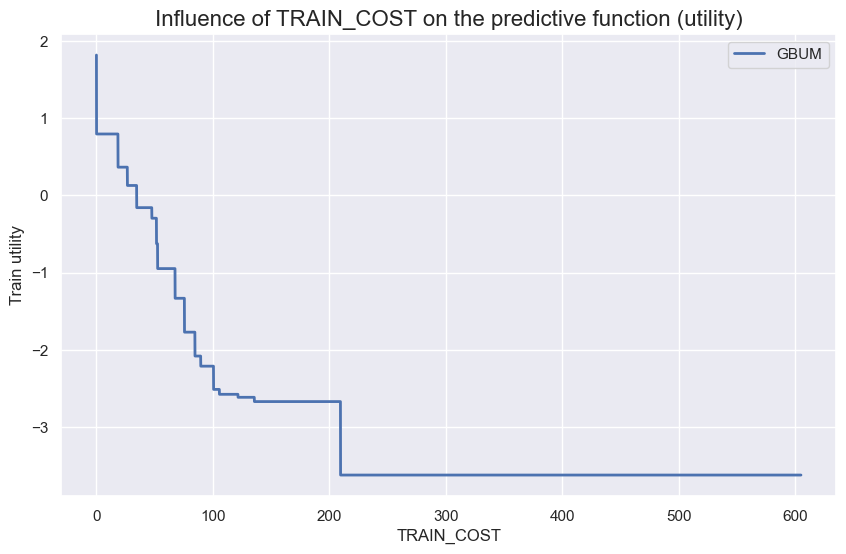

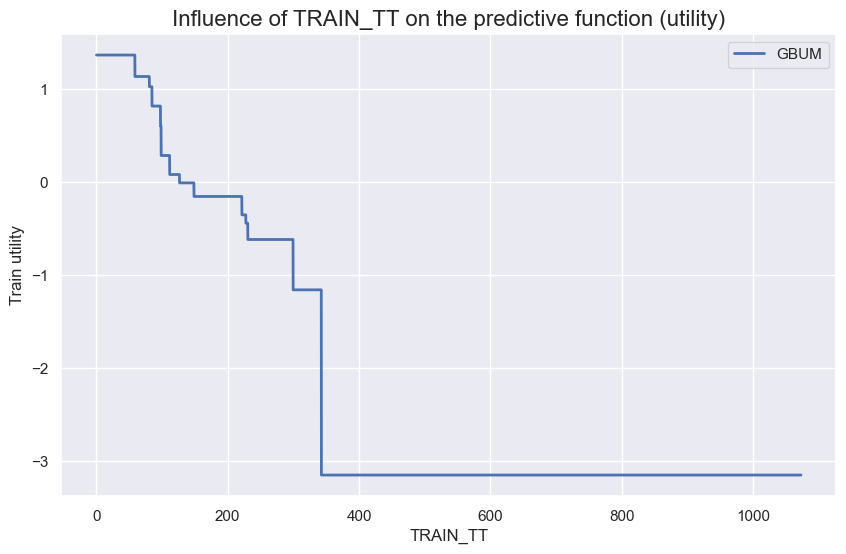

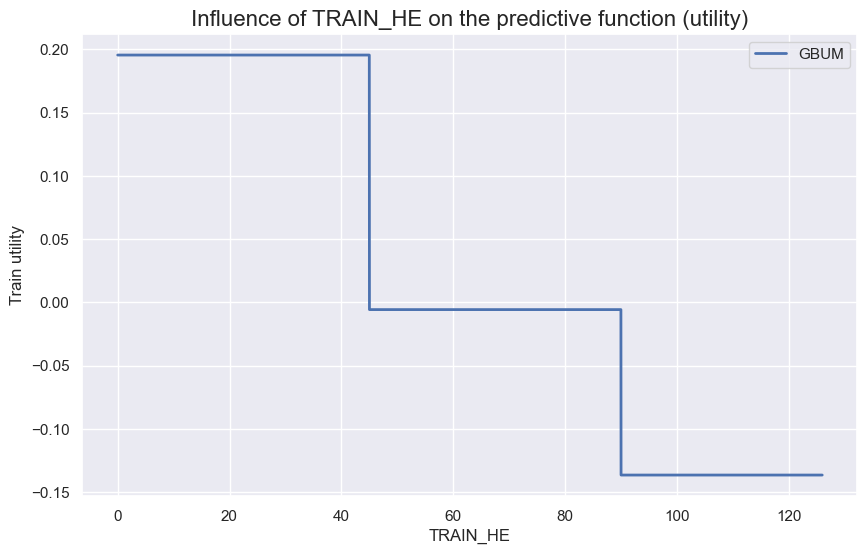

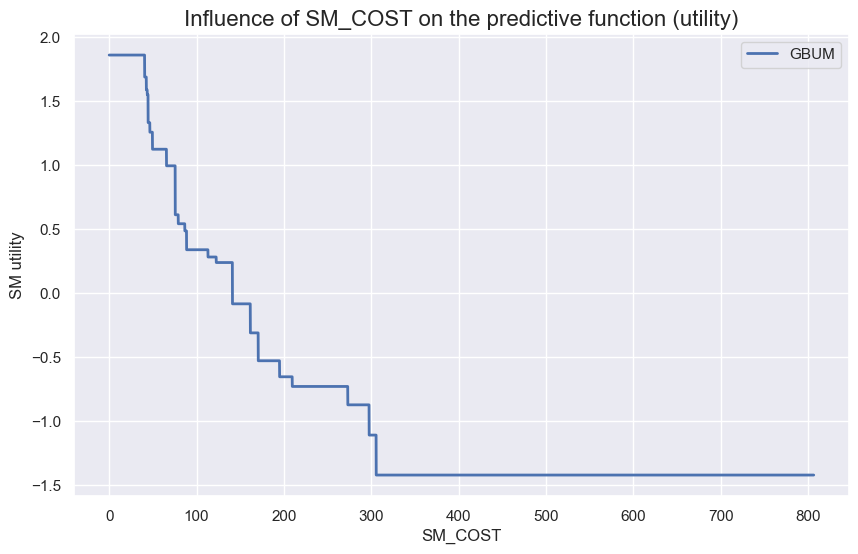

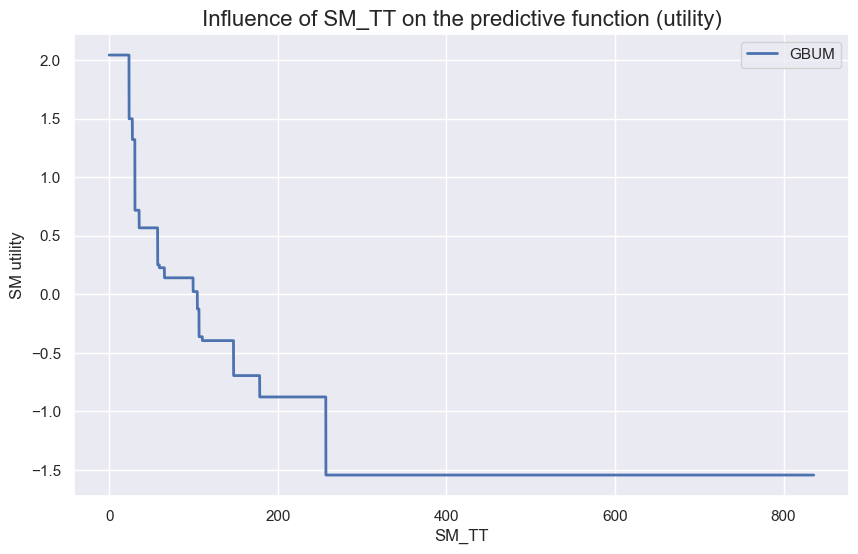

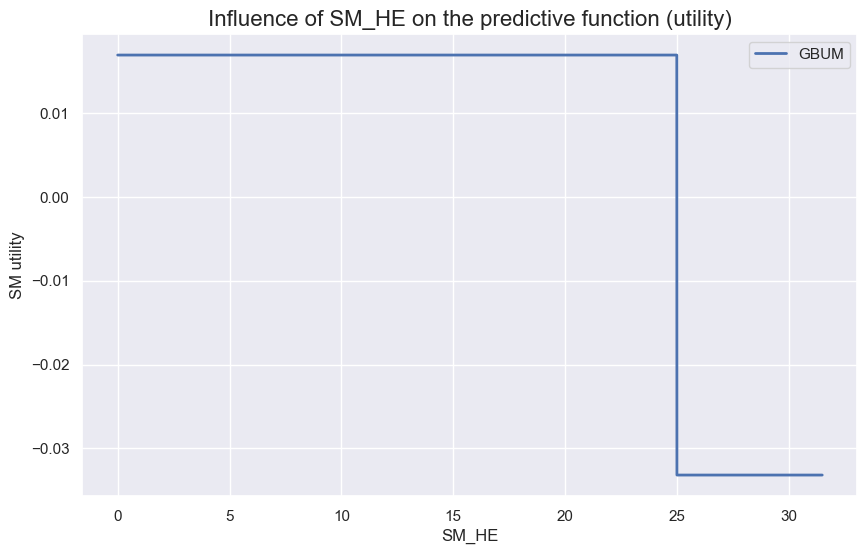

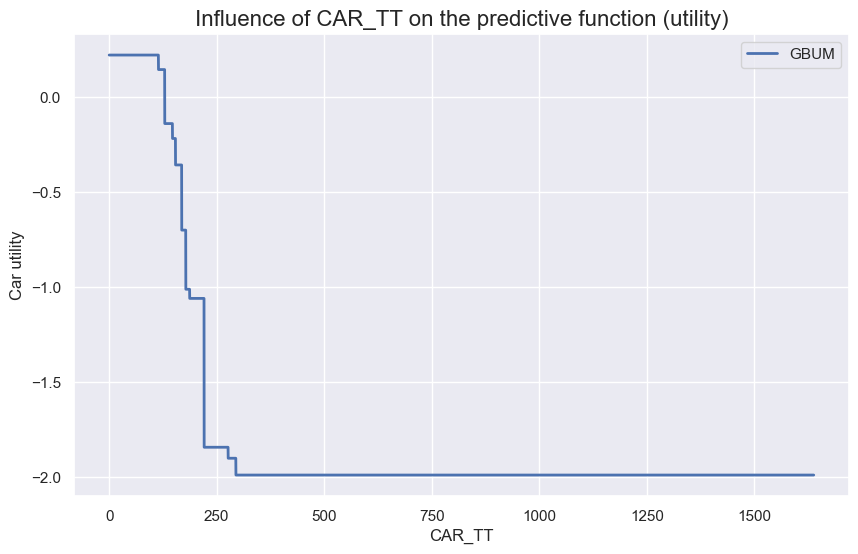

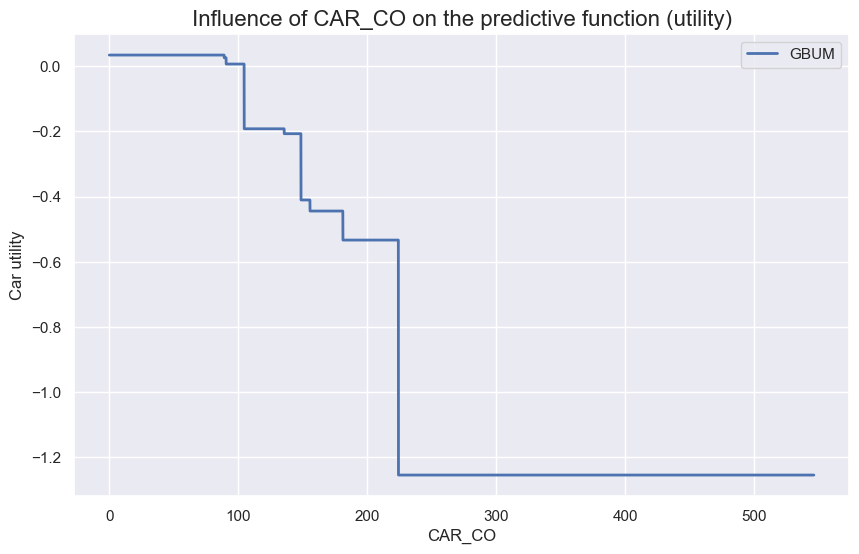

In [8]:
utility_names = {'0': 'Train', '1': 'SM', '2': 'Car'}

rumb_demo.plot_parameters(params, df_train, utility_names)